# Minkowski dot
> Does using Minkowski dot-products for classification do better?

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from src.hyperdt.toy_data import generate_gaussian_mixture_hyperboloid
from src.hyperdt.toy_data import wrapped_normal_mixture
from src.hyperdt.tree import HyperbolicDecisionTreeClassifier

from sklearn.model_selection import train_test_split

In [8]:
# Regular tree versus minkowski version

# X, y = generate_gaussian_mixture_hyperboloid(
X, y = wrapped_normal_mixture(num_points=1000, num_classes=2, n_dim=2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
tree1 = HyperbolicDecisionTreeClassifier(max_depth=2)
tree1.fit(X_train, y_train)
print(tree1.score(X_test, y_test))


# class HDT_Minkowski(HyperbolicDecisionTreeClassifier):
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)
#         self.metric = "minkowski"

#     def _dot(self, X, dim, theta):
#         if self.dot_product and X.ndim == 1:
#             return (
#                 -np.cos(theta) * X[self.timelike_dim] + np.sin(theta) * X[dim]
#             )
#         elif self.sparse_dot_product:
#             return (
#                 -np.cos(theta) * X[:, self.timelike_dim]
#                 + np.sin(theta) * X[:, dim]
#             )


# tree2 = HDT_Minkowski(max_depth=2)
tree2 = HyperbolicDecisionTreeClassifier(
    max_depth=2, dot_product="sparse_minkowski"
)
tree2.fit(X_train, y_train)
print(tree2.score(X_test, y_test))

0.99
0.995


In [28]:
# Wow, OK! That worked better... let's try many times

# Hyperparameters
MAX_DEPTH = 4

# Main loop
results = pd.DataFrame(columns=["dims", "trial", "minkowski", "dot"])
for dims in range(2, 7):
    print(dims)
    for trial in range(100):
        try:
            # X, y = generate_gaussian_mixture_hyperboloid(
            X, y = wrapped_normal_mixture(
                num_points=1000, num_classes=2, n_dim=dims
            )
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42
            )
            tree1 = HyperbolicDecisionTreeClassifier(
                max_depth=MAX_DEPTH, timelike_dim=0
            )
            tree1.fit(X_train, y_train)
            tree2 = HyperbolicDecisionTreeClassifier(
                max_depth=MAX_DEPTH,
                timelike_dim=0,
                dot_product="sparse_minkowski",
            )
            tree2.fit(X_train, y_train)
            results.loc[len(results)] = [
                dims,
                trial,
                tree1.score(X_test, y_test),
                tree2.score(X_test, y_test),
            ]
        except Exception as e:
            print(str(e))
            continue

results

2


3
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
4
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
5
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Cannot project a vector of norm 0. in the Minkowski space to the hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
Points must lie on a hyperboloid
6
Points must lie on a

,dims,trial,minkowski,dot
0,2.0,0.0,0.990,0.990
1,2.0,1.0,0.975,0.975
2,2.0,2.0,1.000,1.000
3,2.0,3.0,0.940,0.940
4,2.0,5.0,0.760,0.760
...,...,...,...,...
401,6.0,78.0,1.000,1.000
402,6.0,84.0,1.000,1.000
403,6.0,91.0,1.000,1.000
404,6.0,94.0,1.000,1.000


<Axes: xlabel='dims'>

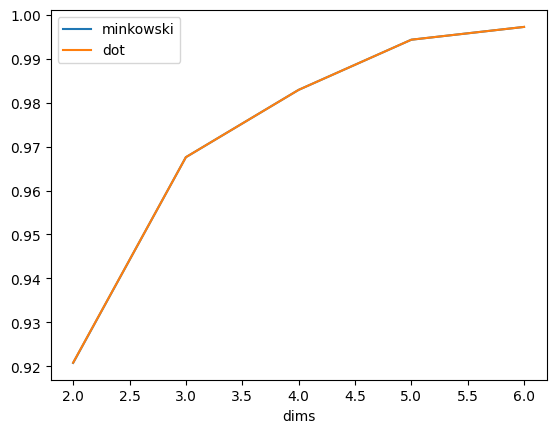

In [30]:
results.groupby("dims")[["minkowski", "dot"]].mean().plot()

array([<Axes: title={'center': 'minkowski'}, xlabel='dims'>,
       <Axes: title={'center': 'dot'}, xlabel='dims'>], dtype=object)

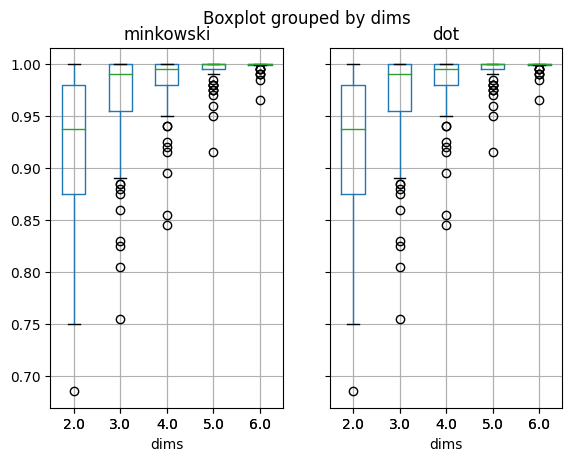

In [31]:
# So here we can see that we always do better with regular dot product. This
# makes sense since the regular Euclidean dot product has the interpretation of
# "to one side of the hyperplane" and "to the other side of the hyperplane",
# and the Minkowski dot product does not have this interpretation.

results.boxplot(column=["minkowski", "dot"], by="dims")

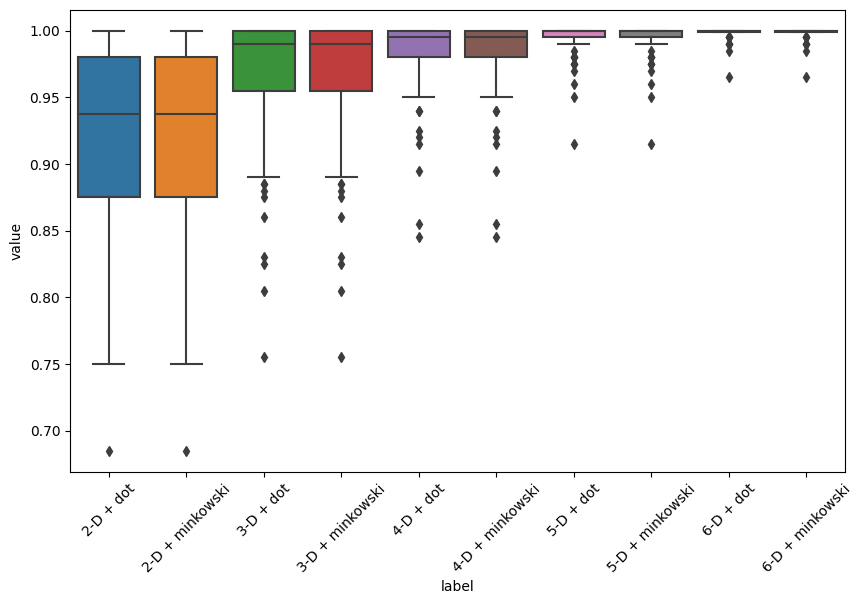

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the dataframe
df_melted = results.melt(
    id_vars=["dims"],
    value_vars=["minkowski", "dot"],
    var_name="metric",
    value_name="value",
).sort_values(by=["dims", "metric"])

# Create custom labels
df_melted["label"] = (
    df_melted["dims"].astype(int).astype(str) + "-D + " + df_melted["metric"]
)

# Plot
plt.figure(figsize=[10, 6])
sns.boxplot(x="label", y="value", data=df_melted)
plt.xticks(rotation=45)
plt.show()

In [27]:
df_melted.sort_values("dims")

,dims,metric,value,label
793,2.0,dot,0.930,2-D + dot
72,2.0,minkowski,1.000,2-D + minkowski
71,2.0,minkowski,0.910,2-D + minkowski
70,2.0,minkowski,1.000,2-D + minkowski
69,2.0,minkowski,0.970,2-D + minkowski
...,...,...,...,...
1562,6.0,dot,0.995,6-D + dot
1563,6.0,dot,0.985,6-D + dot
1564,6.0,dot,0.995,6-D + dot
1584,6.0,dot,1.000,6-D + dot


In [ ]:
# Ok, this is interesting. So using the Minkowski norm is actually helpful, maybe.